### Exercise 1
 * Using the Sobel operator described and the generic convolution (week 2) operation, plot the filter response for a grayscale transformed RGB image.
 * Repeat it with the Prewitt kernel.

In [1]:
from scipy.signal import convolve2d
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = cv.imread("bender.png")
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
])
sobel_y = np.array([
    [1, 2, 1],
    [0, 0, -0],
    [-1, -2, -1],
])
sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

prewitt_x = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1],
])
prewitt_y = np.array([
    [1, 1, 1],
    [0, 0, -0],
    [-1, -1, -1],
])
prewitt = np.sqrt(np.square(prewitt_x) + np.square(prewitt_y))


In [2]:
print(sobel)
print(prewitt)

[[1.41421356 2.         1.41421356]
 [2.         0.         2.        ]
 [1.41421356 2.         1.41421356]]
[[1.41421356 1.         1.41421356]
 [1.         0.         1.        ]
 [1.41421356 1.         1.41421356]]


The sobel operator accentuates vertical contours on the x-axis.

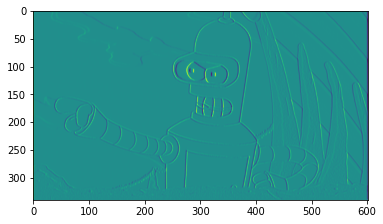

In [3]:
img = convolve2d(gray, sobel_x)
plt.imshow(img)

And horizontal ones on the y-axis.

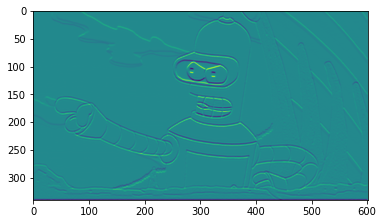

In [4]:
img = convolve2d(gray, sobel_y)
plt.imshow(img)

We can accentuate both horizontal and vertical contours applying the filter on both the x and y-axis.

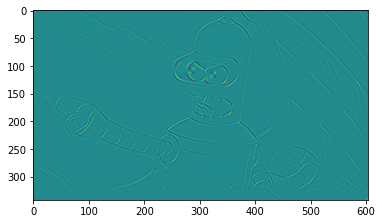

In [5]:
img_sobel = convolve2d(convolve2d(gray, sobel_y), sobel_x)
plt.imshow(img_sobel)

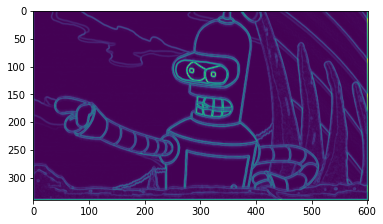

In [6]:
sob_x = convolve2d(gray, sobel_x)
sob_y = convolve2d(gray, sobel_y)
plt.imshow(np.sqrt(np.square(sob_x) + np.square(sob_y)))

Prewitt filter is similar

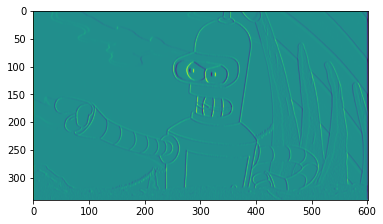

In [7]:
img = convolve2d(gray, prewitt_x)
plt.imshow(img)

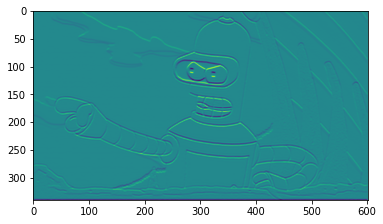

In [8]:
img = convolve2d(gray, prewitt_y)
plt.imshow(img)

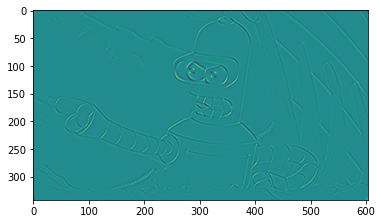

In [9]:
img_prewitt = convolve2d(convolve2d(gray, prewitt_x), prewitt_y)
plt.imshow(img_prewitt)

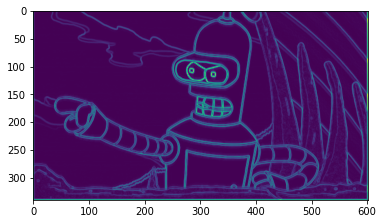

In [10]:
prr_x = convolve2d(gray, prewitt_x)
prr_y = convolve2d(gray, prewitt_y)
plt.imshow(np.sqrt(np.square(prr_x) + np.square(prr_y)))

Both filters stacked on each other have eliminated most of the details from the image, except for some of the most accentuated contours.

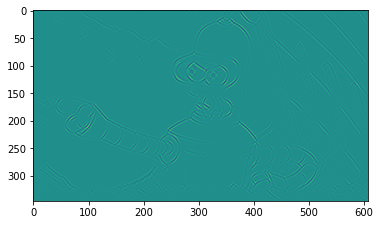

In [10]:
img = convolve2d(convolve2d(img_sobel, prewitt_x), prewitt_y)
plt.imshow(img)

### Exercise 2
* Using the eigenfilter defined for the last exercise, analyze the filter response with respect to increasing the patch size. Relate the behaviour to the covariance matrix magnitude.

In [11]:
from numpy.linalg import eig


def top_eigenvalues(local_patch):
    eps = 1e-14
    normalized_lp = (local_patch - local_patch.min()) / (local_patch.max() - local_patch.min() + eps)
    covar_matrix = np.cov(normalized_lp)
    eigen_vals, eigen_vect = eig(np.nan_to_num(covar_matrix))
    return np.sort(eigen_vals)[0:3]


def eigen_filter(input_image, patch_size, agg_function):
    h, w = input_image.shape
    h_c, w_c = patch_size

    d_h = h_c // 2
    d_w = w_c // 2

    # apply zero-padding for the input image
    oper_image = np.zeros((h + 2 * d_h, w + 2 * d_w))
    oper_image[d_h:(h + d_h), d_w:(w + d_w)] = input_image
    output_img = np.zeros((h, w, 3))

    for i in range(h):
        for j in range(w):
            l_i = i + d_h
            l_j = j + d_w
            patch = oper_image[(l_i - d_h):(l_i + d_h + 1), (l_j - d_w):(l_j + d_w + 1)]
            output_img[i, j, :] = agg_function(patch)

    output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min())
    return output_img

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


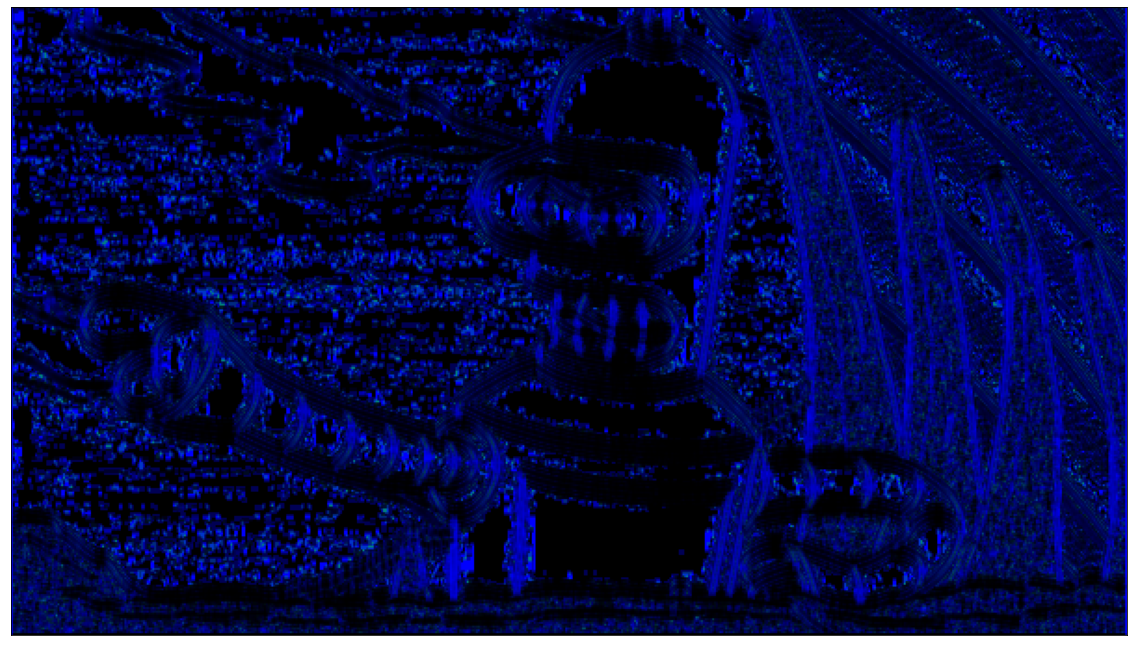

In [12]:
output = eigen_filter(gray, (3, 3), top_eigenvalues)
plt.figure(figsize=(20, 20))
plt.xticks([])
plt.yticks([])
plt.imshow(output)

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


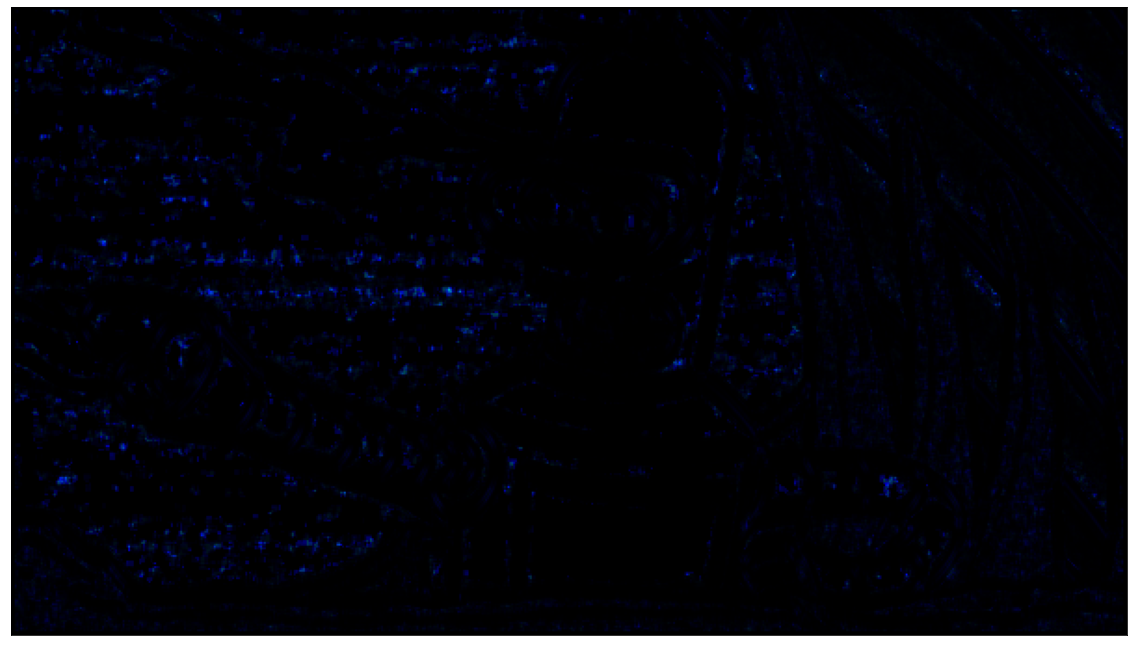

In [13]:
output = eigen_filter(gray, (5, 5), top_eigenvalues)
plt.figure(figsize=(20, 20))
plt.xticks([])
plt.yticks([])
plt.imshow(output)

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


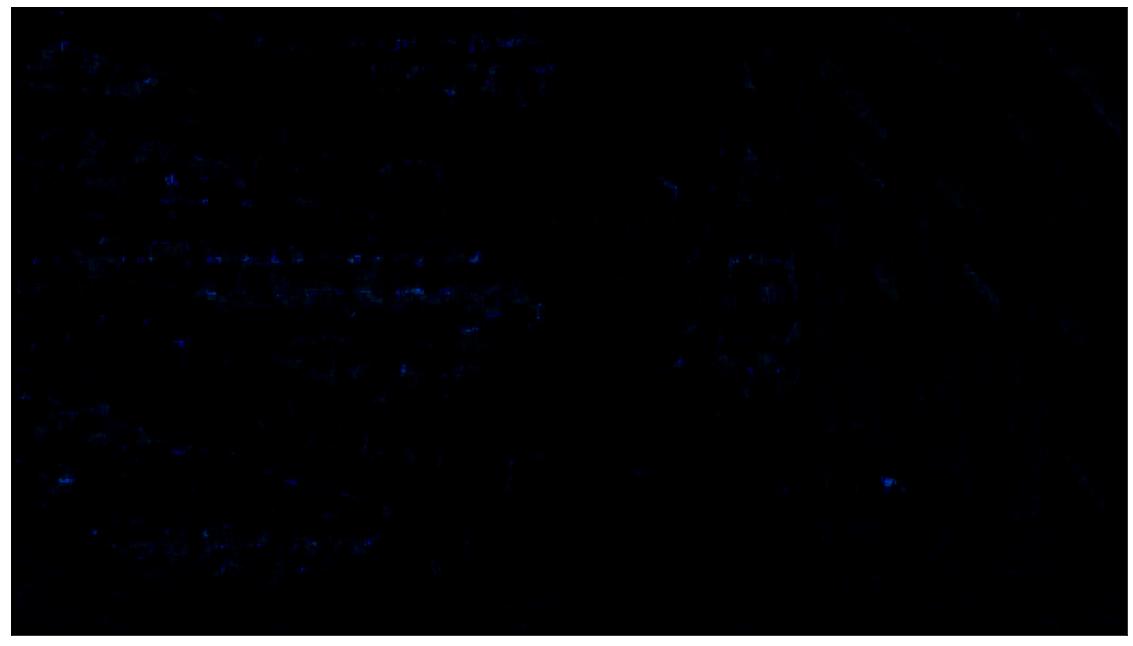

In [14]:
output = eigen_filter(gray, (7, 7), top_eigenvalues)
plt.figure(figsize=(20, 20))
plt.xticks([])
plt.yticks([])
plt.imshow(output)

We can observe that with the increase in patch size the eigen response becomes darker and darker. This is due to the fact that the magnitude of covariance may be skewed whenever the data set contains too many significantly different values.

### Exercise 3
 * Using the definition for the eigenfilter defined in this exercise, replace the local patch approach by a k-nearest neighbors approach. Analyze the response of the filter and describe the difference to the response of the local patch approach. Discuss the behavior of the filter when increasing the number of neighbors.

In [19]:
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import eig


def top_eigenvalues(local_patch):
    eps = 1e-14
    normalized_lp = (local_patch - local_patch.min()) / (local_patch.max() - local_patch.min() + eps)
    covar_matrix = np.cov(normalized_lp)
    eigen_vals, eigen_vect = eig(np.nan_to_num(covar_matrix))
    return np.sort(eigen_vals)[0:3]


def eigen_filter(input_image, patch_size, agg_function):
    h, w = input_image.shape
    h_c, w_c = patch_size

    d_h = h_c // 2
    d_w = w_c // 2

    # apply zero-padding for the input image
    oper_image = np.zeros((h + 2 * d_h, w + 2 * d_w))
    oper_image[d_h:(h + d_h), d_w:(w + d_w)] = input_image
    output_img = np.zeros((h, w, 3))

    knn = NearestNeighbors(n_neighbors=2)
    knn.fit(oper_image)

    distances, indices = knn.kneighbors(oper_image, return_distance=False)
    print(indices)

    # for i in range(h):
    #     for j in range(w):
    #         l_i = i + d_h
    #         l_j = j + d_w
    #         patch = oper_image[(l_i - d_h):(l_i + d_h + 1), (l_j - d_w):(l_j + d_w + 1)]
    #         output_img[i, j, :] = agg_function(patch)
    #
    # output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min())
    # return output_img

output = eigen_filter(gray, (5, 5), top_eigenvalues)

[[  0   1]
 [  0   1]
 [  2   3]
 [  3   2]
 [  4   5]
 [  5   6]
 [  6   5]
 [  7   8]
 [  8   9]
 [  9   8]
 [ 10  11]
 [ 11  12]
 [ 12  11]
 [ 13  12]
 [ 14  15]
 [ 15  14]
 [ 16  15]
 [ 17  18]
 [ 18  17]
 [ 19  20]
 [ 20  21]
 [ 21  20]
 [ 22  21]
 [ 23  24]
 [ 24  23]
 [ 25  26]
 [ 26  27]
 [ 27  26]
 [ 28  27]
 [ 29  30]
 [ 30  29]
 [ 31  30]
 [ 32  33]
 [ 33  32]
 [ 34  33]
 [ 35  36]
 [ 36  35]
 [ 37  36]
 [ 38  39]
 [ 39  38]
 [ 40  41]
 [ 41  42]
 [ 42  41]
 [ 43  44]
 [ 44  45]
 [ 45  44]
 [ 46  47]
 [ 47  48]
 [ 48  47]
 [ 49  50]
 [ 50  51]
 [ 51  50]
 [ 52  53]
 [ 53  54]
 [ 54  53]
 [ 55  56]
 [ 56  57]
 [ 57  56]
 [ 58  59]
 [ 59  60]
 [ 60  59]
 [ 61  62]
 [ 62  63]
 [ 63  62]
 [ 64  63]
 [ 65  66]
 [ 66  65]
 [ 67  66]
 [ 68  69]
 [ 69  68]
 [ 70  69]
 [ 71  72]
 [ 72  71]
 [ 73  72]
 [ 74  75]
 [ 75  74]
 [ 76  75]
 [ 77  78]
 [ 78  77]
 [ 79  78]
 [ 80  81]
 [ 81  80]
 [ 82  83]
 [ 83  84]
 [ 84  83]
 [ 85  84]
 [ 86  87]
 [ 87  86]
 [ 88  87]
 [ 89  90]
 [ 90  89]

### Exercise 4
 * Use the local patch eigenfilter approach as feature extractor for the SVC classifier. Compare the missclassification rate to the one produced by the same model with features defined as the Local Binary Pattern histogram.

In [16]:
import os
from imutils import paths
from skimage import feature
from sklearn.svm import LinearSVC

data = []
labels = []
path = "dataset/train"


def describe_eigen_filter(image, radius, num_points, eps=1e-7):
		pattern = eigen_filter(gray, (3, 3), top_eigenvalues)

		(hist, _) = np.histogram(pattern.ravel(),
			            bins=np.arange(0, num_points + 3),
			            range=(0, num_points + 2))

		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		return hist


for image_path in paths.list_images(path):
    # load the image, convert it to grayscale, and describe it
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    hist = describe_eigen_filter(gray, radius=8, num_points=24)
    # extract the label from the image path, then update the
    # label and data lists
    labels.append(image_path.split(os.path.sep)[-2])
    data.append(hist)

# train a Linear SVM on the data
model = LinearSVC(C=100.0, random_state=42)
model.fit(data, labels)

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)
c:\users\georges\documents\facultate\master\an1\s2\uaic_fii_cv\pythonproject\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=100.0, random_state=42)

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


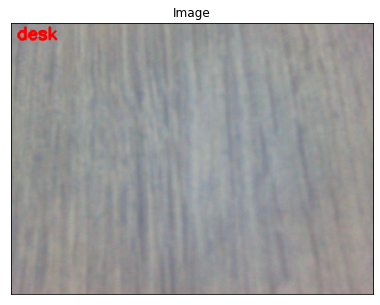

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


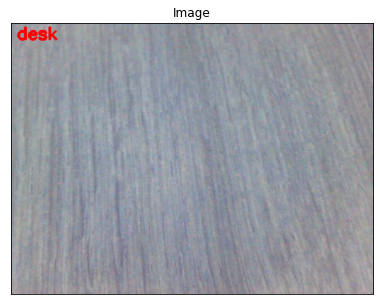

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


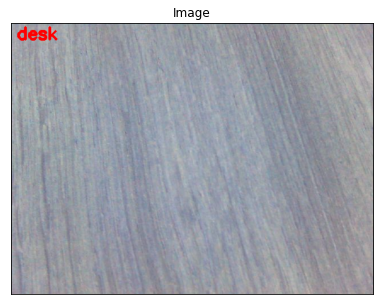

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


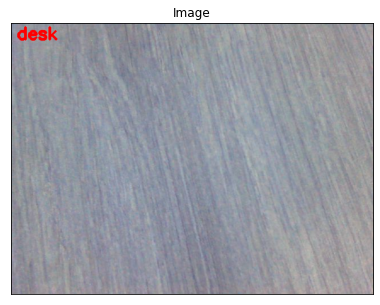

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


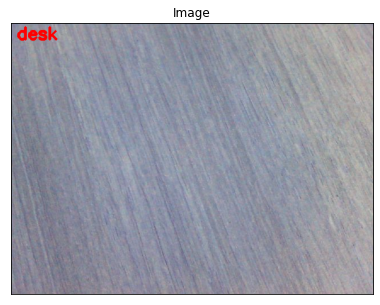

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


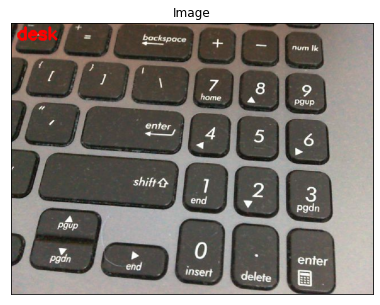

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


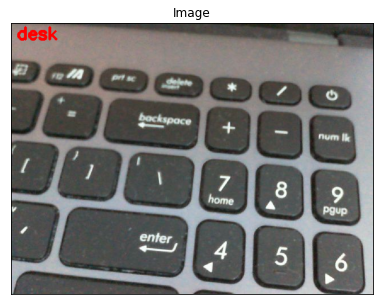

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


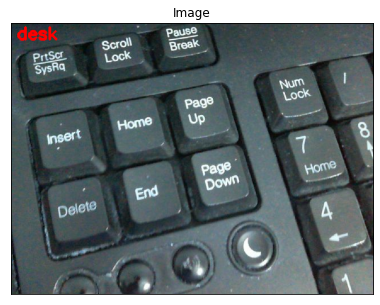

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


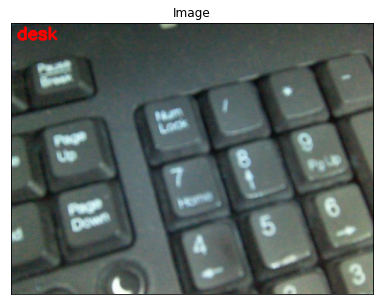

C:\Users\GeorgeS\AppData\Local\Temp\ipykernel_18240\564388996.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  output_img[i, j, :] = agg_function(patch)


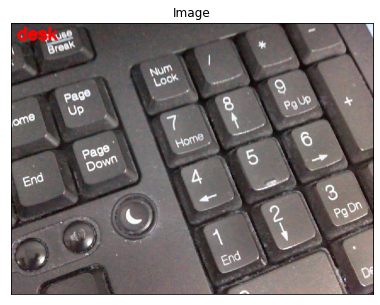

In [17]:
# simple function to display the results
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


# process the test data to assess the performance of the model

test_path = "dataset/test"

for image_path in paths.list_images(test_path):
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    hist = describe_eigen_filter(gray, radius=8, num_points=24)
    prediction = model.predict(hist.reshape(1, -1))

    # display the image and the prediction
    cv.putText(image, prediction[0], (10, 30), cv.FONT_HERSHEY_SIMPLEX,
               1.0, (255, 0, 0), 3)
    visualize(image=image)

We can see that compared to  the Local Binary Pattern histogram, features extracted using the eigenfilter have better solutions in classification.